# Sandbox Reconhecimento de Rostos

In [63]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6')

# Detecção

In [64]:
img = cv2.imread('/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/imagens_teste/yan_teste.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_cinza = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [65]:
img_rgb.shape

(1600, 1200, 3)

In [66]:
img_cinza.shape

(1600, 1200)

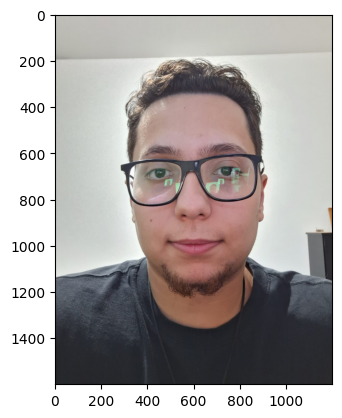

In [67]:
plt.imshow(img_rgb)

In [68]:
def draw_faces(img, faces_and_landmarks, color):
    if faces_and_landmarks is not None:
        # Para cada rosto detectado, desenha um retângulo ao redor do rosto
        for face in faces_and_landmarks[1]:
            bbox = face[:4].astype(int)  # Extrai as coordenadas da caixa delimitadora
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color, 2)  # Desenha o retângulo
            # cv2.putText(img, f'Score: {face[14]:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)  # Adiciona o texto na imagem
    return img

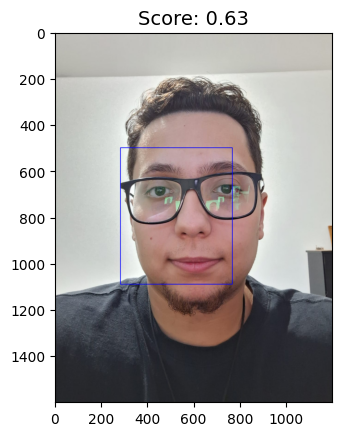

In [69]:
# Inicializa FaceDetectorYN com parâmetros
nms_threshold = 0.3
score_threshold = 0.5
yunet_shape = (img.shape[1], img.shape[0])
topk = 50000

# Inicializa o detector de rosto
detector = cv2.FaceDetectorYN.create(
    "modelos/face_detection_yunet_2023mar.onnx", 
    "", 
    yunet_shape,
    score_threshold, 
    nms_threshold, 
    topk
)

detector.setInputSize((img.shape[1], img.shape[0]))
faces_and_landmarks = detector.detect(img_rgb)

rosto = draw_faces(
    img = img_rgb,
    faces_and_landmarks=faces_and_landmarks,
    color=(0, 0, 255)
)

plt.title(f'Score: {faces_and_landmarks[1][0][14]:.2f}', fontsize = 14)
plt.imshow(rosto)

In [70]:
def detecta_rosto(caminho_imagem, score_threshold=0.7):

    # Convertendo a imagem para escala de cinza
    img = cv2.imread(caminho_imagem)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_cinza = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Inicializa FaceDetectorYN com parâmetros
    nms_threshold = 0.3
    yunet_shape = (img_cinza.shape[1], img_cinza.shape[0])
    topk = 50000

    # Inicializa o detector de rosto
    detector = cv2.FaceDetectorYN.create(
        "modelos/face_detection_yunet_2023mar.onnx",
        "",
        yunet_shape,
        score_threshold,
        nms_threshold,
        topk
    )

    # Configurando o tamanho de entrada do detector de rosto
    detector.setInputSize((img_cinza.shape[1], img_cinza.shape[0]))

    # Detectando rostos na imagem
    success, faces_and_landmarks = detector.detect(img_rgb)

    if not success:
        print("Nenhum rosto detectado.")
        return None

    return faces_and_landmarks

# Classificação

In [71]:
def extrai_rosto(recognizer, caminho_imagem, score_threshold = 0.7):

    # Lendo imagem e mudando as cores
    img = cv2.imread(caminho_imagem)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Extrai o array de rosto
    rosto_alinhado = recognizer.alignCrop(img_rgb, detecta_rosto(caminho_imagem, score_threshold))
    facial_features = recognizer.feature(rosto_alinhado)

    return facial_features

In [73]:
# Inicializa FaceRecognizerSF
recognizer = cv2.FaceRecognizerSF.create("/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/modelos/face_recognition_sface_2021dec_int8.onnx", "")

# yan1 = extrai_rosto(recognizer, caminho_imagem='/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/yan_teste.jpeg', score_threshold = 0.5)
# yan2 = extrai_rosto(recognizer, caminho_imagem='/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/yan_teste2.jpeg', score_threshold = 0.5)
# messi = extrai_rosto(recognizer, caminho_imagem='/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/messi.jpeg', score_threshold = 0.5)

In [74]:
os.listdir('dados/imagens_treino')

['yan', 'nic', 'vampeta', 'gabriel']

In [79]:
imagem_busca = '/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/imagens_teste/yan_teste.jpeg'
busca = extrai_rosto(recognizer, caminho_imagem=imagem_busca,  score_threshold = 0.5)

pontuacao_max = 0
pessoa_detectada = ''

for pessoa in os.listdir('dados/imagens_treino'):
    pontuacoes = []
    for imagem in os.listdir(f'/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/imagens_treino/{pessoa}'):
        if ('png' in imagem or 'jpeg' in imagem):
            rosto = extrai_rosto(recognizer, caminho_imagem=f'/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6/dados/imagens_treino/{pessoa}/{imagem}', score_threshold = 0.5)
            pontuacao = recognizer.match(busca, rosto, cv2.FACE_RECOGNIZER_SF_FR_COSINE)
            pontuacoes.append(pontuacao)

    pontuacao_media = np.mean(pontuacoes)
    print(f'{pessoa} => {pontuacao_media:.2f}')
    if  pontuacao_media > pontuacao_max:
        pontuacao_max = pontuacao_media
        pessoa_detectada = pessoa

print('=' * 50)
print(f'Pessoa detectada: {pessoa_detectada}, Pontuação: {pontuacao_max:.2f}')

Yan => 0.76
Nic => 0.25
Vampeta => 0.06
Gabriel => 0.14
Pessoa detectada: Yan, Pontuação: 0.76
